<a href="https://colab.research.google.com/github/Sivasubramaniansivanayagam/IBM_Time_Series_specialization/blob/main/Time_Series_IBM_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#About Data
The dataset for this project originates from kaggle S&P 500  and contains Historical stock data for all current S&P 500 companies between 2013 and feb 2018

In this project, we will use "**FB Prophet**" and "**Long Short-Term Memory (LSTM)**" to predict stock market indices. We are interested in forecasting the 'Close' series of AMZN.

All the files have the following columns:
Date - in format: yy-mm-dd

Open - price of the stock at market open (this is NYSE data so all in USD)

High - Highest price reached in the day

Low Close - Lowest price reached in the day

Volume - Number of shares traded

Name - the stock's ticker name

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
import tensorflow as tf
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error
from prophet.plot import plot_plotly, plot_components_plotly

In [3]:
df_s_and_p=pd.read_csv("/content/drive/MyDrive/all_stocks_5yr.csv")

In [4]:
df_s_and_p

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


# Exploratory data analysis
## we are intrested in AMZN stocks hence filtering the AMZN

In [5]:
df_amzn=df_s_and_p[df_s_and_p["Name"]=="AMZN"]

In [6]:
df_amzn.reset_index(inplace=True) 
df_amzn

,index,date,open,high,low,close,volume,Name
0,46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
1,46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
2,46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
3,46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
4,46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN
...,...,...,...,...,...,...,...,...
1254,47641,2018-02-01,1445.00,1459.88,1385.140,1390.00,9113808,AMZN
1255,47642,2018-02-02,1477.39,1498.00,1414.000,1429.95,11125722,AMZN
1256,47643,2018-02-05,1402.62,1458.98,1320.720,1390.00,11494985,AMZN
1257,47644,2018-02-06,1361.46,1443.99,1351.790,1442.84,11066819,AMZN


In [7]:
df_amzn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB


In [8]:
df_amzn["date"]=pd.to_datetime(df_amzn["date"],format="%Y-%m-%d")

<ipython-input-8-802bce282428>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_amzn["date"]=pd.to_datetime(df_amzn["date"],format="%Y-%m-%d")


In [9]:
len(df_amzn.date.unique())

1259

In [10]:
df_amzn.isna().sum()

index     0
date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

 We are intrested in date and close price

In [11]:
df_amzn=df_amzn[["date","close"]]

In [12]:
df_amzn

,date,close
0,2013-02-08,261.95
1,2013-02-11,257.21
2,2013-02-12,258.70
3,2013-02-13,269.47
4,2013-02-14,269.24
...,...,...
1254,2018-02-01,1390.00
1255,2018-02-02,1429.95
1256,2018-02-05,1390.00
1257,2018-02-06,1442.84


In [13]:
fig=px.line(df_amzn.set_index("date"))
fig.show()

Text(0.5, 1.0, 'AMAZON price over period of time')

<Figure size 800x800 with 0 Axes>

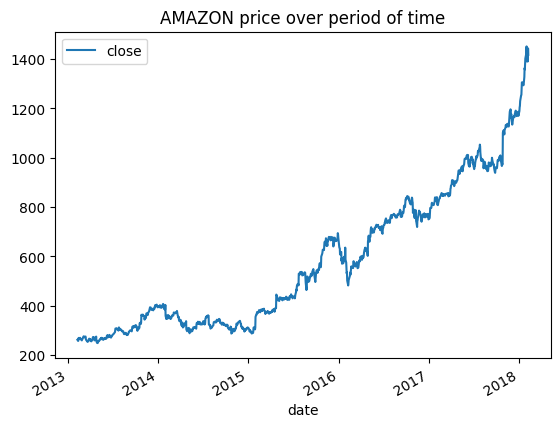

In [14]:
plt.figure(figsize=(8,8))
df_amzn.set_index("date").plot()
plt.title("AMAZON price over period of time")

 Looking at the plot there is a upward trend

 # Prophet model and spliting the data train 80% and 20% test

In [15]:
df_amzn.columns=["ds","y"]

In [16]:
df_amzn

,ds,y
0,2013-02-08,261.95
1,2013-02-11,257.21
2,2013-02-12,258.70
3,2013-02-13,269.47
4,2013-02-14,269.24
...,...,...
1254,2018-02-01,1390.00
1255,2018-02-02,1429.95
1256,2018-02-05,1390.00
1257,2018-02-06,1442.84


In [17]:
len(df_amzn.ds.unique())*0.80

1007.2

In [18]:
train=df_amzn.iloc[:1000]
test=df_amzn.iloc[1000:]

# Prophet Model

In [19]:
model=Prophet()
model.add_country_holidays(country_name="US")
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjwnn_ho/ds0sx77r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjwnn_ho/duhbwqn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63201', 'data', 'file=/tmp/tmprjwnn_ho/ds0sx77r.json', 'init=/tmp/tmprjwnn_ho/duhbwqn6.json', 'output', 'file=/tmp/tmprjwnn_ho/prophet_modeldvx0hkk_/prophet_model-20230527162718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:27:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:27:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [20]:
predicted=model.predict(test.drop(columns="y"))

In [21]:
plot_plotly(model,predicted)

In [22]:
plot_components_plotly(model,predicted)

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:870: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



# Accuracy of the prophet forecast

In [23]:
rmse=np.sqrt(mean_squared_error(test["y"],predicted["yhat"]))
mape=mean_absolute_percentage_error(test["y"],predicted["yhat"])

In [24]:
print("RMSE",rmse)
print("MAPE",mape)

RMSE 136.6697440372429
MAPE 0.08889996182939555


# LSTM model

In [25]:
# Create a new dataframe with only the 'Close column 
data = df_amzn.set_index("ds")
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

1008

In [26]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [27]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        

[array([0.01140805, 0.00746678, 0.0087057 , 0.01766085, 0.01746961,
       0.01401892, 0.01789367, 0.01511649, 0.01472569, 0.01429332,
       0.00967855, 0.00925449, 0.01248898, 0.0133371 , 0.01455939,
       0.02068748, 0.02274957, 0.02125289, 0.02132772, 0.02158549,
       0.01913259, 0.0215356 , 0.02234214, 0.01455939, 0.01129995,
       0.0080322 , 0.00680159, 0.00752332, 0.00429049, 0.00791579,
       0.00647731, 0.0100444 , 0.01419354, 0.01518301, 0.01112534,
       0.01254885, 0.00898009, 0.00902167, 0.0060283 , 0.00891357,
       0.01073454, 0.01375285, 0.01797682, 0.02048792, 0.01620574,
       0.02004723, 0.01593967, 0.00930438, 0.01005272, 0.01273843,
       0.0171869 , 0.01708712, 0.02200955, 0.00547121, 0.00125555,
       0.00463972, 0.        , 0.00359204, 0.00816523, 0.00622786])]
[0.007899156868940521]

[array([0.01140805, 0.00746678, 0.0087057 , 0.01766085, 0.01746961,
       0.01401892, 0.01789367, 0.01511649, 0.01472569, 0.01429332,
       0.00967855, 0.00925449, 0.0

In [28]:
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(948, 60, 1)

# Train LSTM

* LSTM with 32 hidden units per cell
* Define the loss function and optimizer strategy
* Fit the model with 10 epochs
* Predict and plot the results

In [29]:
l_model=tf.keras.Sequential([tf.keras.layers.LSTM(32,return_sequences=True,input_shape= (x_train.shape[1], 1)),
                             tf.keras.layers.LSTM(32,return_sequences=False),
                             tf.keras.layers.Dense(32),
                             tf.keras.layers.Dense(1)])

l_model.compile(optimizer="adam",loss="mean_squared_error")


In [30]:
l_model.fit(x_train,y_train,batch_size=1,epochs=10)

Epoch 1/10
948/948 [==============================] - 20s 8ms/step - loss: 8.1048e-04
Epoch 2/10
948/948 [==============================] - 7s 8ms/step - loss: 3.1998e-04
Epoch 3/10
948/948 [==============================] - 6s 7ms/step - loss: 3.2727e-04
Epoch 4/10
948/948 [==============================] - 7s 8ms/step - loss: 2.2437e-04
Epoch 5/10
948/948 [==============================] - 6s 7ms/step - loss: 2.0544e-04
Epoch 6/10
948/948 [==============================] - 7s 8ms/step - loss: 1.6604e-04
Epoch 7/10
948/948 [==============================] - 6s 7ms/step - loss: 1.3978e-04
Epoch 8/10
948/948 [==============================] - 7s 8ms/step - loss: 1.8154e-04
Epoch 9/10
948/948 [==============================] - 7s 7ms/step - loss: 1.3188e-04
Epoch 10/10
948/948 [==============================] - 7s 8ms/step - loss: 1.3098e-04


In [31]:
l_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,761
Trainable params: 13,761
Non-trainable params: 0
_________________________________________________________________


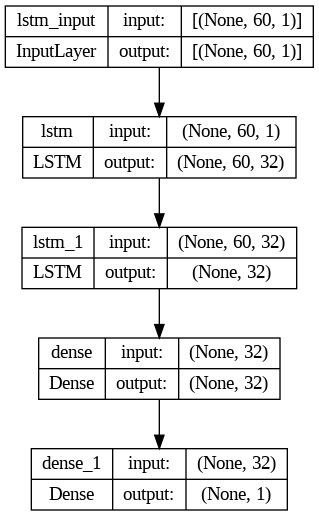

In [32]:
from tensorflow.keras.utils import plot_model

plot_model(model=l_model, show_shapes=True)

In [33]:
32*32+32

1056

In [34]:
training_data_len - 60

948

In [35]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = l_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

8/8 [==============================] - 1s 4ms/step


20.272560823481772

In [36]:
x_test.shape

(251, 60, 1)

In [37]:
pd.DataFrame(y_test.reshape(251,-1))

,0
0,821.36
1,827.46
2,836.53
3,836.39
4,842.70
...,...
246,1390.00
247,1429.95
248,1390.00
249,1442.84


In [38]:
pd.DataFrame(x_test.reshape(251,-1))

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.408079,0.391499,0.411596,0.414298,0.422538,0.425665,0.442162,0.446593,0.442261,0.442469,...,0.491344,0.488534,0.484052,0.478315,0.485690,0.492009,0.467273,0.465144,0.469185,0.475180
1,0.391499,0.411596,0.414298,0.422538,0.425665,0.442162,0.446593,0.442261,0.442469,0.431161,...,0.488534,0.484052,0.478315,0.485690,0.492009,0.467273,0.465144,0.469185,0.475180,0.476552
2,0.411596,0.414298,0.422538,0.425665,0.442162,0.446593,0.442261,0.442469,0.431161,0.427627,...,0.484052,0.478315,0.485690,0.492009,0.467273,0.465144,0.469185,0.475180,0.476552,0.481624
3,0.414298,0.422538,0.425665,0.442162,0.446593,0.442261,0.442469,0.431161,0.427627,0.417691,...,0.478315,0.485690,0.492009,0.467273,0.465144,0.469185,0.475180,0.476552,0.481624,0.489166
4,0.422538,0.425665,0.442162,0.446593,0.442261,0.442469,0.431161,0.427627,0.417691,0.411937,...,0.485690,0.492009,0.467273,0.465144,0.469185,0.475180,0.476552,0.481624,0.489166,0.489049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0.717884,0.725417,0.727504,0.735578,0.732460,0.729317,0.732493,0.738871,0.730431,0.739245,...,0.868982,0.870030,0.897244,0.926538,0.922355,0.939351,0.959390,0.972386,0.989132,1.000000
247,0.725417,0.727504,0.735578,0.732460,0.729317,0.732493,0.738871,0.730431,0.739245,0.733083,...,0.870030,0.897244,0.926538,0.922355,0.939351,0.959390,0.972386,0.989132,1.000000,0.949371
248,0.727504,0.735578,0.732460,0.729317,0.732493,0.738871,0.730431,0.739245,0.733083,0.730115,...,0.897244,0.926538,0.922355,0.939351,0.959390,0.972386,0.989132,1.000000,0.949371,0.982589
249,0.735578,0.732460,0.729317,0.732493,0.738871,0.730431,0.739245,0.733083,0.730115,0.741074,...,0.926538,0.922355,0.939351,0.959390,0.972386,0.989132,1.000000,0.949371,0.982589,0.949371


# LSTM ACCURACY is better than Prophet

In [39]:
np.sqrt(mean_squared_error(y_test, predictions))


20.272560823481772

In [40]:
mean_absolute_percentage_error(y_test, predictions)

0.011692148423724137

<ipython-input-42-d18af2bb7351>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



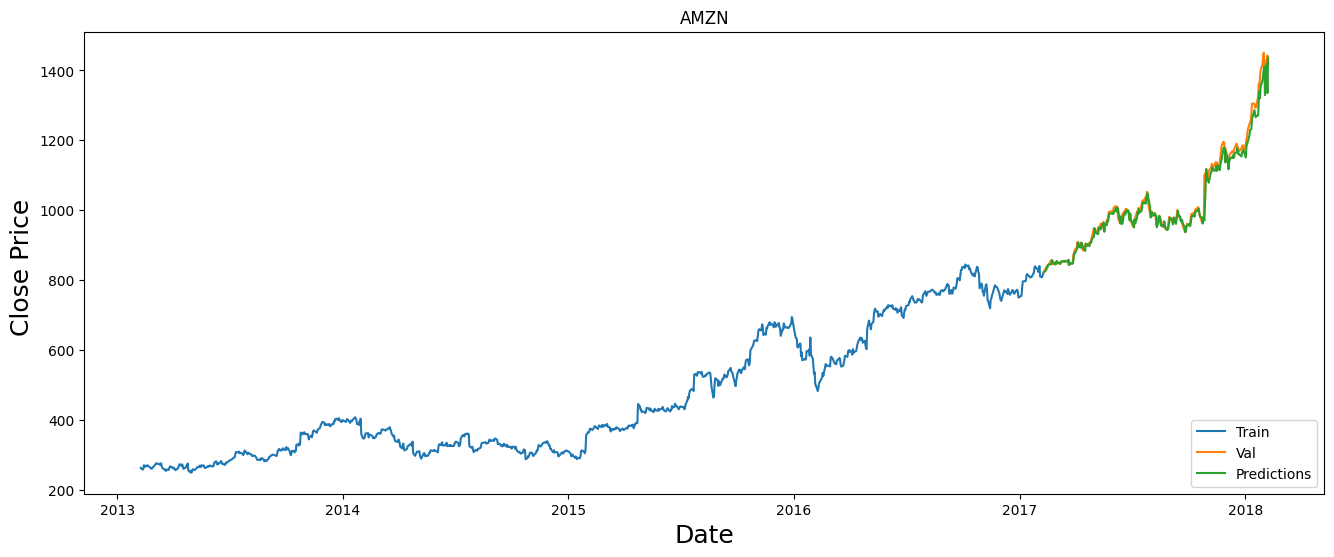

In [42]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('AMZN')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ', fontsize=18)
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Insights and key findings

If we compare model summary for LSTM, we can see that there are more trainable parameters for the LSTM, which explains why it took a longer time to train this model.

* Overall prophet seems to be faster in training and not required pre_processing data other than changing the column names to ds and y. accuracy is not the best compared with LSTM
* LSTM requires higher training period and lot of transformation before training but it provides awesome accuracy.

# Next Steps
To improve the quality of forecasts for prophet we can try changing the parameters or providing the custom holidays period.